# Descriptive statistics

## 1 Setup

First, setup the database

In [1]:
from utils import setup_spreadr
setup_spreadr('spreadr_exp_1')

Then import all we need for the analysis

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.metrics import edit_distance
import numpy as np
import seaborn as sb

from gists.models import Sentence, Profile

from utils import memoized

And equip our models with useful tools: head of a sentence, easy narrowing of a queryset to a bucket

In [3]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

## 2 Transformation rate ~ profile variables

First equip our models with some distances and content extraction tools

In [4]:
from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

Then compute all transformation rates

In [5]:
def compute_rates(distance_type):
    rates = []
    profiles = Profile.objects.all()
    print('Computing {} transformation rates on {} profiles...'.format(distance_type, len(profiles)), end='')
    for i, profile in enumerate(profiles):
        try:
            print(' {}'.format(i + 1), end='')
            rates.append(profile.transformation_rate(distance_type))
        except ValueError:
            # Profile has no reformulations
            pass
    print()

    return np.array(rates)

In [6]:
raw_rates = compute_rates('raw')
ordered_content_rates = compute_rates('ordered_content')

Computing raw transformation rates on 66 profiles... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
Computing ordered_content transformation rates on 66 profiles... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66


Plot them

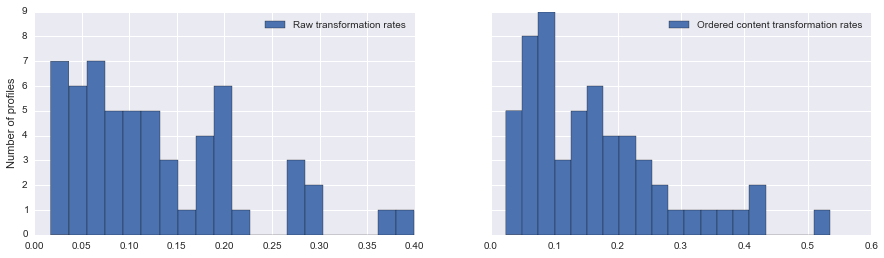

In [7]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 4), squeeze=True)
axes[0].hist(raw_rates, 20, label='Raw transformation rates')
axes[0].legend();
axes[0].set_ylabel('Number of profiles')
axes[1].hist(ordered_content_rates, 20, label='Ordered content transformation rates')
axes[1].legend();